# Two Input Classifier

This notebook considers an ANN classifier with just 2 inputs on the unit square.
The truth values are the result of a complex equation.
I use an image on the unit square to report on the progress of the classifier.

These results suggest that more hidden layers are needed to fit non-linear edge cases.
Using a single layer with 300 nodes doesn't work as well as 3 layers with 100 nodes.

## Preliminaries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print('tf version: {}'.format(tf.VERSION))

tf version: 1.7.0


`N` is a top level control parameter.
Higher values creates a some complex problem.

In [3]:
N=5

`samples` creates `n` pairs of inputs.
`ysfor` evaluates `xs` without any noise.

In [4]:
def samples(n):
    return np.random.random((n, 2))

def ysfor(xs):
    """return truth values"""
    return np.int64(np.greater(np.cos(xs[:,0] * N * np.pi), np.sin(xs[:,1] * N * np.pi)))

`SAMPLES` is the number of sample points on the unit square.

In [5]:
SAMPLES=100
samplexs = np.array([  [i/SAMPLES, j/SAMPLES] for i in range(SAMPLES) for j in range(SAMPLES) ])
sampleys = ysfor(samplexs)
img = np.array(sampleys)
img.shape = (SAMPLES, SAMPLES)

`train` runs an entire simulation: generates input data, creates an multi-layer ANN, reports training and testing progress and displays output images.
There are 3 output images per session: the true image, the correct prediction image and the progress image.
Each sample point in the progress image is incremented each iteration is it was correctly predicted.

In [6]:
def train(epochs, ntrain, ntest, layers,
          modeldir='TwoInput', learning_rate=0.01, threshold=0.94):

    trainingxs = samples(ntrain)
    testingxs = samples(ntest)
    
    trainingys = ysfor(trainingxs)
    testingys = ysfor(testingxs)

    if tf.gfile.Exists(modeldir):
        tf.gfile.DeleteRecursively(modeldir)
    tf.gfile.MakeDirs(modeldir)

    def weight_variable(shape):
        """Create a weight variable with appropriate initialization."""
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)
    
    def bias_variable(shape):
        """Create a bias variable with appropriate initialization."""
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)
    
    def variable_summaries(var):
        """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
        with tf.name_scope('summaries'):
            mean = tf.reduce_mean(var)
            #tf.summary.scalar('mean', mean)
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            #tf.summary.scalar('stddev', stddev)
            #tf.summary.scalar('max', tf.reduce_max(var))
            #tf.summary.scalar('min', tf.reduce_min(var))
            tf.summary.histogram('histogram', var)
        return
    
    def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
        """Reusable code for making a simple neural net layer.
        It does a matrix multiply, bias add, and then uses ReLU to nonlinearize.
        It also sets up name scoping so that the resultant graph is easy to read,
        and adds a number of summary ops.
        """
        with tf.name_scope(layer_name):
            with tf.name_scope('weights'):
                weights = weight_variable([input_dim, output_dim])
                variable_summaries(weights)
            with tf.name_scope('biases'):
                biases = bias_variable([output_dim])
                variable_summaries(biases)
            with tf.name_scope('Wx_b'):
                preactivate = tf.matmul(input_tensor, weights) + biases
                #tf.summary.histogram('pre_activations', preactivate)
        activations = act(preactivate, name='activation')
        #tf.summary.histogram('activations', activations)
        return activations
    
    inputwidth = trainingxs.shape[1]
        
    tf.reset_default_graph()

    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, [None, inputwidth], name='x-input')
        y_ = tf.placeholder(tf.int64, [None], name='y-input')

    def prep(xs, ys):
        """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
        return {x: xs, y_: ys}

    cnt = 0
    inputlayer = x
    for layer in layers:
        inputlayer = nn_layer(inputlayer, inputwidth, layer, 'layer%d' % cnt)
        inputwidth = layer
        cnt = cnt + 1

    y = nn_layer(inputlayer, inputwidth, 2, 'logit', act=tf.identity) # not using softmax

    with tf.name_scope('cross_entropy'):
        with tf.name_scope('total'):
            cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y_, logits=y) # softmax here
        tf.summary.scalar('train', cross_entropy)

    with tf.name_scope('train'):
        train_step = tf.train.ProximalAdagradOptimizer(learning_rate).minimize(cross_entropy)  

    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(tf.argmax(y, 1), y_)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('test', accuracy)

    merged = tf.summary.merge_all()
    
    sess = tf.InteractiveSession()

    train_writer = tf.summary.FileWriter(modeldir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(modeldir + '/test')

    tf.global_variables_initializer().run()
    saver = tf.train.Saver(max_to_keep=1)
    
    samplepred = sess.run([correct_prediction], feed_dict=prep(samplexs, sampleys))[0]
    tsimp = samplepred.astype(float)
    
    for i in range(epochs):
        if (i+1) % 100 != 0:
            sess.run([train_step], feed_dict=prep(trainingxs, trainingys))
        else:
            _, summary, acc0 = sess.run([train_step, merged, accuracy], feed_dict=prep(trainingxs, trainingys))
            train_writer.add_summary(summary, i)

            acc1 = sess.run(accuracy, feed_dict=prep(testingxs, testingys))
            test_writer.add_summary(summary, i)
            print(" {:4.2f}-{:4.2f}".format(acc0, acc1), end='', flush=True)
            if (i+1) % 1000 == 0:
                print(' {:05d}'.format(i+1))
            
            if acc1 > threshold:
                saver.save(sess, modeldir + '/model', global_step=i)
                break
            
            saver.save(sess, modeldir + '/model', global_step=i)
            
            samplepred = sess.run([correct_prediction], feed_dict=prep(samplexs, sampleys))[0]
            tsimp = tsimp + samplepred.astype(float)

    print('')

    train_writer.close()
    test_writer.close()
    
    def plot(img, title):
        plt.imshow(img, cmap="gray")
        plt.gca().set_title(title)
        plt.show()
        return

    plot(img, 'Truth')
    
    samplepred = sess.run([correct_prediction], feed_dict=prep(samplexs, sampleys))[0]
    simp = samplepred.astype(int)
    simp.shape = (SAMPLES, SAMPLES)
    plot(simp, 'Correct Predictions')

    tsimp.shape = (SAMPLES, SAMPLES)
    plot(tsimp, 'Progress')
    
    sess.close()

    print('Finished')
    return

## Results

Each 100th iteration reports accuracy on the training data set and the test data set.
Iterations are stopped when the accuracy threshold is met.
In the 'Correct Predictions' image, white pixels are correct and black pixels are wrong.
In the 'Progress' image, darker pixels are incorrect for more iterations.

This simulation uses a 3 hidden layer ANN.
Strangely, the progress image has a notable vertical characteristic.

 0.55-0.54 0.55-0.54 0.55-0.54 0.55-0.54 0.55-0.54 0.55-0.54 0.55-0.54 0.55-0.54 0.55-0.54 0.55-0.54 01000
 0.55-0.54 0.55-0.54 0.55-0.54 0.58-0.56 0.55-0.56 0.56-0.62 0.56-0.64 0.54-0.65 0.55-0.65 0.57-0.65 02000
 0.57-0.65 0.57-0.65 0.57-0.66 0.57-0.67 0.58-0.68 0.58-0.69 0.58-0.69 0.59-0.70 0.59-0.70 0.60-0.70 03000
 0.61-0.70 0.62-0.70 0.63-0.69 0.65-0.70 0.67-0.70 0.70-0.69 0.73-0.71 0.74-0.72 0.75-0.74 0.75-0.75 04000
 0.76-0.76 0.77-0.77 0.77-0.77 0.77-0.78 0.77-0.78 0.77-0.79 0.78-0.78 0.78-0.79 0.79-0.80 0.79-0.79 05000
 0.80-0.81 0.79-0.80 0.80-0.81 0.80-0.80 0.81-0.81 0.79-0.79 0.81-0.82 0.80-0.80 0.83-0.85 0.83-0.84 06000
 0.85-0.85 0.85-0.86 0.87-0.87 0.85-0.88 0.86-0.88 0.89-0.90 0.91-0.91 0.90-0.91 0.92-0.92 0.91-0.91 07000
 0.88-0.89 0.92-0.92 0.93-0.94 0.91-0.91 0.92-0.93 0.94-0.95 0.90-0.91 0.93-0.93 0.95-0.95 0.93-0.92 08000
 0.91-0.91 0.93-0.93 0.95-0.95 0.96-0.96 0.95-0.95 0.96-0.96 0.95-0.94 0.95-0.94 0.93-0.93 0.93-0.93 09000
 0.95-0.94 0.96-0.96 0.96-0.96 0.95-0

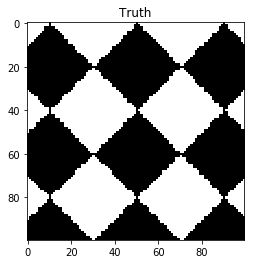

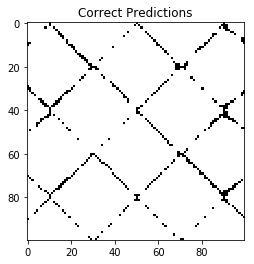

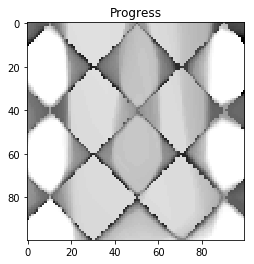

Finished


In [15]:
train(epochs=10000, ntrain=10000, ntest=1000, layers=[30, 30, 30], learning_rate=0.1, threshold=0.98)

This simulation uses a larger 3 hidden layer ANN.
The progress image still has a notable vertical characteristic.

 0.56-0.54 0.56-0.54 0.56-0.54 0.60-0.54 0.65-0.57 0.65-0.63 0.64-0.60 0.65-0.61 0.66-0.65 0.66-0.67 01000
 0.66-0.66 0.67-0.66 0.68-0.66 0.71-0.67 0.74-0.72 0.76-0.76 0.76-0.74 0.78-0.75 0.80-0.80 0.82-0.83 02000
 0.83-0.84 0.84-0.84 0.84-0.83 0.85-0.85 0.85-0.84 0.86-0.85 0.89-0.88 0.87-0.86 0.85-0.84 0.89-0.87 03000
 0.89-0.89 0.86-0.86 0.92-0.93 0.90-0.89 0.90-0.90 0.92-0.92 0.92-0.93 0.91-0.91 0.93-0.92 0.92-0.91 04000
 0.93-0.92 0.94-0.94 0.93-0.91 0.93-0.92 0.93-0.92 0.93-0.92 0.93-0.93 0.95-0.94 0.93-0.92 0.93-0.92 05000
 0.94-0.93 0.94-0.93 0.95-0.94 0.96-0.95 0.95-0.94 0.94-0.93 0.96-0.96 0.96-0.95 0.95-0.94 0.96-0.96 06000
 0.93-0.93 0.97-0.95 0.97-0.96 0.97-0.97 0.97-0.96 0.97-0.96 0.97-0.96 0.97-0.97 0.97-0.96 0.97-0.96 07000
 0.97-0.96 0.97-0.96 0.97-0.95 0.97-0.96 0.97-0.96 0.97-0.97 0.97-0.96 0.98-0.97 0.98-0.97 0.98-0.97 08000
 0.94-0.94 0.97-0.96 0.98-0.97 0.99-0.98


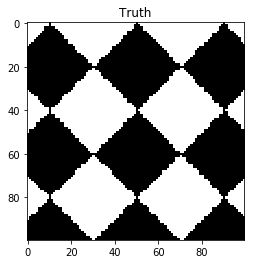

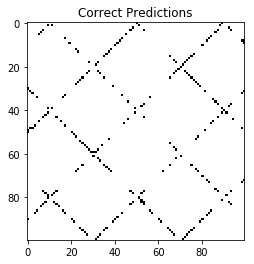

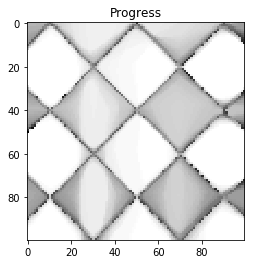

Finished


In [7]:
train(epochs=10000, ntrain=10000, ntest=1000, layers=[100, 100, 100], learning_rate=0.1, threshold=0.98)

This simulation uses an even larger single hidden layer ANN.
The progress image doesn't have the vertical characteristic,
but the edges are not fit as well.

 0.55-0.57 0.55-0.57 0.55-0.57 0.56-0.58 0.56-0.59 0.55-0.57 0.55-0.56 0.56-0.56 0.59-0.59 0.56-0.65 01000
 0.60-0.66 0.59-0.67 0.61-0.68 0.61-0.68 0.62-0.68 0.63-0.68 0.64-0.68 0.66-0.68 0.66-0.67 0.67-0.67 02000
 0.67-0.67 0.67-0.67 0.67-0.67 0.68-0.67 0.68-0.68 0.69-0.69 0.69-0.70 0.70-0.71 0.70-0.71 0.71-0.71 03000
 0.72-0.72 0.73-0.73 0.75-0.73 0.75-0.74 0.76-0.75 0.77-0.75 0.77-0.75 0.78-0.76 0.79-0.76 0.79-0.77 04000
 0.80-0.77 0.81-0.78 0.81-0.78 0.81-0.79 0.82-0.79 0.82-0.80 0.83-0.80 0.83-0.80 0.84-0.81 0.84-0.81 05000
 0.84-0.82 0.85-0.82 0.85-0.83 0.85-0.83 0.85-0.84 0.86-0.84 0.86-0.84 0.86-0.84 0.86-0.84 0.87-0.84 06000
 0.87-0.84 0.87-0.85 0.87-0.85 0.87-0.85 0.87-0.85 0.87-0.85 0.88-0.85 0.88-0.85 0.88-0.85 0.88-0.85 07000
 0.88-0.85 0.88-0.85 0.88-0.85 0.88-0.85 0.88-0.86 0.88-0.86 0.88-0.86 0.89-0.86 0.89-0.86 0.89-0.86 08000
 0.89-0.86 0.89-0.86 0.89-0.87 0.89-0.87 0.89-0.87 0.89-0.87 0.89-0.87 0.89-0.87 0.89-0.87 0.89-0.87 09000
 0.89-0.87 0.89-0.87 0.89-0.87 0.89-0

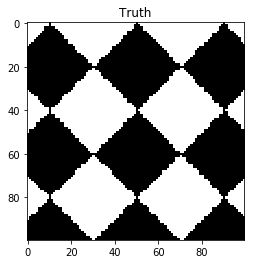

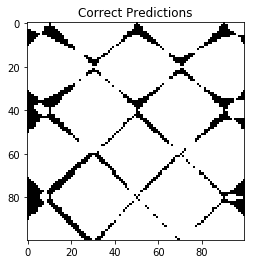

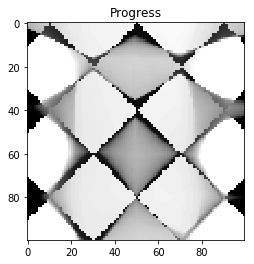

Finished


In [8]:
train(epochs=10000, ntrain=10000, ntest=1000, layers=[300], learning_rate=0.1, threshold=0.98)

This simulation uses a larger two hidden layer ANN.
The progress image does have the vertical characteristic,
and the edges are not fit a bit better.

 0.55-0.54 0.58-0.58 0.64-0.62 0.65-0.63 0.65-0.65 0.65-0.67 0.65-0.66 0.67-0.66 0.68-0.65 0.70-0.66 01000
 0.71-0.69 0.72-0.71 0.74-0.73 0.75-0.75 0.76-0.76 0.77-0.76 0.78-0.78 0.79-0.79 0.80-0.81 0.79-0.80 02000
 0.81-0.81 0.81-0.80 0.81-0.82 0.82-0.83 0.82-0.82 0.83-0.84 0.84-0.86 0.84-0.84 0.85-0.85 0.85-0.84 03000
 0.85-0.86 0.86-0.87 0.87-0.87 0.81-0.82 0.87-0.88 0.88-0.88 0.89-0.88 0.89-0.88 0.89-0.88 0.89-0.89 04000
 0.90-0.89 0.91-0.90 0.90-0.89 0.90-0.90 0.90-0.90 0.92-0.90 0.91-0.90 0.91-0.90 0.92-0.91 0.90-0.90 05000
 0.91-0.91 0.91-0.90 0.93-0.92 0.92-0.92 0.92-0.91 0.92-0.92 0.92-0.92 0.93-0.92 0.91-0.91 0.93-0.92 06000
 0.93-0.92 0.92-0.92 0.93-0.92 0.93-0.92 0.94-0.93 0.93-0.93 0.93-0.92 0.94-0.94 0.94-0.93 0.94-0.93 07000
 0.94-0.93 0.93-0.93 0.94-0.94 0.94-0.94 0.94-0.93 0.94-0.94 0.94-0.93 0.94-0.94 0.94-0.94 0.94-0.94 08000
 0.94-0.94 0.94-0.94 0.95-0.95 0.95-0.94 0.94-0.94 0.95-0.95 0.94-0.94 0.95-0.95 0.95-0.94 0.95-0.95 09000
 0.95-0.95 0.95-0.95 0.95-0.95 0.95-0

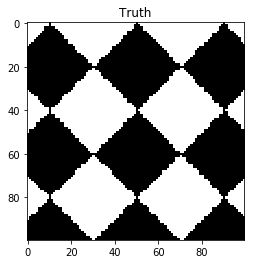

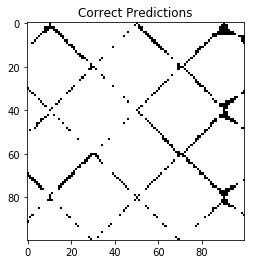

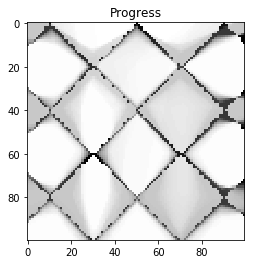

Finished


In [9]:
train(epochs=10000, ntrain=10000, ntest=1000, layers=[300, 300], learning_rate=0.1, threshold=0.98)

This simulation uses a two hidden layer ANN with a low threshold to show the early progress in the fitting.
The correct prediction image has a strong vertical characteristic.
There are many incorrect sample points.

 0.56-0.57 0.56-0.57 0.56-0.57 0.56-0.57 0.56-0.57 0.56-0.57 0.56-0.57 0.56-0.57 0.58-0.58 0.56-0.63 01000



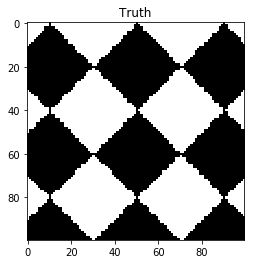

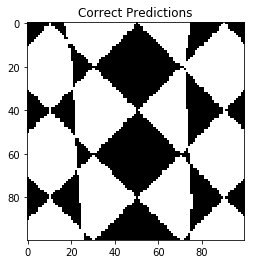

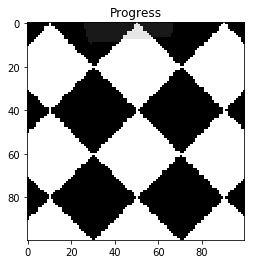

Finished


In [7]:
train(epochs=10000, ntrain=10000, ntest=1000, layers=[30, 30], learning_rate=0.1, threshold=0.6)

This simulation uses a two hidden layer ANN with a moderate threshold to show more progress in the fitting.
The correct prediction image has a strong vertical and horizontal characteristics.
The vertical characteristic is apparent in the progress image.
Sample points in the center of regions are correct.
The progress image has a strong vertical characteristic.

 0.56-0.54 0.56-0.54 0.56-0.54 0.56-0.54 0.56-0.54 0.56-0.54 0.56-0.54 0.56-0.54 0.56-0.54 0.56-0.54 01000
 0.56-0.54 0.57-0.54 0.59-0.60 0.59-0.60 0.59-0.60 0.59-0.60 0.59-0.61 0.58-0.61 0.59-0.61 0.59-0.61 02000
 0.59-0.61 0.59-0.61 0.60-0.62 0.60-0.62 0.61-0.62 0.62-0.62 0.63-0.62 0.65-0.63 0.66-0.63 0.67-0.63 03000
 0.68-0.64 0.69-0.64 0.69-0.64 0.70-0.65 0.70-0.65 0.70-0.65 0.70-0.65 0.70-0.65 0.71-0.66 0.72-0.68 04000
 0.73-0.70


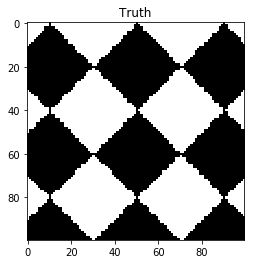

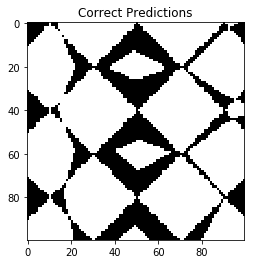

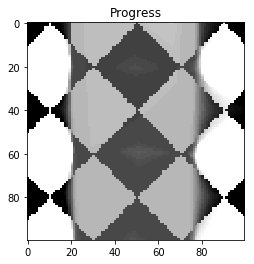

Finished


In [8]:
train(epochs=10000, ntrain=10000, ntest=1000, layers=[30, 30], learning_rate=0.1, threshold=0.7)

This simulation uses a two hidden layer ANN with a moderate, but slightly higher, threshold to show more progress in the fitting.
The correct prediction image has a strong vertical and horizontal characteristics.
The vertical characteristic is apparent in the progress image.
Many sample points are incorrect.
The progress image has a strong vertical and horizontal characteristics.

 0.55-0.52 0.55-0.52 0.55-0.52 0.55-0.52 0.55-0.52 0.55-0.52 0.55-0.52 0.55-0.52 0.55-0.52 0.57-0.53 01000
 0.61-0.58 0.64-0.53 0.66-0.54 0.66-0.56 0.66-0.56 0.66-0.60 0.67-0.64 0.69-0.66 0.70-0.68 0.71-0.65 02000
 0.71-0.64 0.72-0.65 0.72-0.68 0.71-0.71 0.73-0.74 0.74-0.76


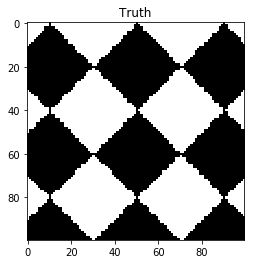

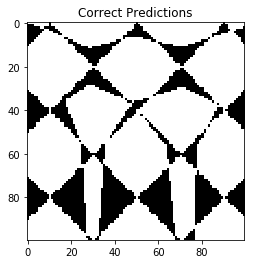

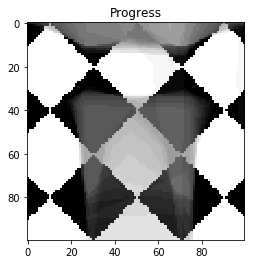

Finished


In [9]:
train(epochs=10000, ntrain=10000, ntest=1000, layers=[30, 30], learning_rate=0.1, threshold=0.75)